In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "../00_setup.py").load_module()

In [2]:
setup.temp_path

'../data/2023_12_15'

# Neural Network Classification Test - Basic

The purpose of this script is to build a standard (not graph) NN and try to get decent performance.  I want to test the data prepared in script 10

Some code based on: https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

https://github.com/stellargraph/stellargraph/issues/1908

*This script takes about 1 hour on my MacBook Air*

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [4]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [5]:
import pandas as pd
import os

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

2023-12-31 12:55:53.619141: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-31 12:55:53.619164: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-31 12:55:53.619171: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-31 12:55:53.619208: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-31 12:55:53.619224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.metrics as km

In [7]:
import tensorflow.keras.metrics as km
from keras import initializers

## Input Data

In [8]:
os.chdir('..')

In [10]:
business_data = pd.read_parquet(Path(setup.temp_path).joinpath('TMP_11_DATA_combined_scaled_all.parquet'))

In [11]:
business_data.describe()

,target,menc_NAICS,menc_NAICS_sector,NS___Accommodation and Food Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),"NS___Professional, Scientific, and Technical Services",NS___Retail Trade,...,new_business,urban_flag,franchise_flag,missingindicator_LowDoc,missingindicator_new_business,missingindicator_urban_flag,NoEmp,CreateJob,LowDoc,DisbursementGross
count,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,...,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,6.880810e+05,6.880810e+05,6.880810e+05,6.880810e+05
mean,0.203011,0.203954,0.202926,0.097958,0.095606,0.079398,0.096843,0.103658,0.098048,0.182085,...,0.277935,0.852639,0.050324,0.007342,0.001235,0.198575,6.691533e-18,-7.517649e-18,-2.368885e-17,-5.093000e-17
std,0.402241,0.095249,0.043782,0.297258,0.294051,0.270359,0.295744,0.304816,0.297380,0.385915,...,0.447982,0.354465,0.218613,0.085371,0.035125,0.398928,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,0.000000,0.009628,0.068505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.824568e-01,-2.086068e-01,-3.314259e-01,-6.420047e-01
25%,0.000000,0.132721,0.192547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.364398e-01,-1.674320e-01,-3.291739e-01,-5.312204e-01
50%,0.000000,0.200864,0.218455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.051958e-01,-1.323106e-01,-3.287489e-01,-3.501667e-01
75%,0.000000,0.264205,0.228565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.235818e-02,-1.341020e-02,-3.287489e-01,7.064531e-02
max,1.000000,0.488372,0.286731,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.560525e+02,3.423551e+02,3.041835e+00,3.773855e+01


In [12]:
business_data.columns

Index(['dset', 'LoanNr_ChkDgt', 'target', 'NAICS', 'NAICS_sector',
       'menc_NAICS', 'menc_NAICS_sector',
       'NS___Accommodation and Food Services', 'NS___Construction',
       'NS___Health Care and Social Assistance', 'NS___Manufacturing',
       'NS___Other Services (except Public Administration)',
       'NS___Professional, Scientific, and Technical Services',
       'NS___Retail Trade', 'NS___Wholesale Trade', 'NS___infrequent_sklearn',
       'new_business', 'urban_flag', 'franchise_flag',
       'missingindicator_LowDoc', 'missingindicator_new_business',
       'missingindicator_urban_flag', 'NoEmp', 'CreateJob', 'LowDoc',
       'DisbursementGross'],
      dtype='object')

In [27]:
feat = ['new_business','urban_flag', 'franchise_flag','missingindicator_LowDoc',
        'missingindicator_new_business', 'missingindicator_urban_flag', 'NoEmp',
        'CreateJob', 'LowDoc', 'DisbursementGross']


In [28]:
X = business_data[['dset', 'LoanNr_ChkDgt'] + feat].set_index('LoanNr_ChkDgt').sort_index()

In [30]:
X.shape

(688081, 11)

In [31]:
X.columns

Index(['dset', 'new_business', 'urban_flag', 'franchise_flag',
       'missingindicator_LowDoc', 'missingindicator_new_business',
       'missingindicator_urban_flag', 'NoEmp', 'CreateJob', 'LowDoc',
       'DisbursementGross'],
      dtype='object')

## Function to create model

In [72]:
def create_baseline(base_thresh  = 0.2, n_feat = 10, hidden_size = 4):
    model = Sequential()
    #model.add(Dense(60, input_shape=(7,), activation='relu'))
    #model.add(Dense(2, input_shape=(10,), activation='relu'))
    model.add(Dense(hidden_size, input_shape=(10,), activation='selu'))
    #model.add(Dense(hidden_size, input_shape=(hidden_size,), activation='selu'))
    model.add(Dense(hidden_size, input_shape=(hidden_size,), activation='linear'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC'), km.Precision(thresholds=base_thresh), 
                           km.Recall(thresholds=base_thresh)])
    return model

## Model Create, Fit

In [73]:
model = create_baseline()

In [65]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
X_train.shape

(412848, 10)

In [66]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
X_val.shape

(220187, 10)

In [67]:
y_train = business_data[business_data['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']

In [68]:
y_train.shape

(412848,)

In [69]:
y_val = business_data[business_data['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=10
)

Epoch 1/10


2024-01-01 07:29:22.241120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4728 - auc_14: 0.2994 - auc_15: 0.6764 - precision_7: 0.2798 - recall_7: 0.8099

2024-01-01 07:32:13.157167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 227s 17ms/step - loss: 0.4728 - auc_14: 0.2994 - auc_15: 0.6764 - precision_7: 0.2798 - recall_7: 0.8099 - val_loss: 0.4699 - val_auc_14: 0.3105 - val_auc_15: 0.6815 - val_precision_7: 0.2827 - val_recall_7: 0.8072
Epoch 2/10
12902/12902 [==============================] - 209s 16ms/step - loss: 0.4706 - auc_14: 0.3069 - auc_15: 0.6802 - precision_7: 0.2826 - recall_7: 0.8043 - val_loss: 0.4697 - val_auc_14: 0.3088 - val_auc_15: 0.6817 - val_precision_7: 0.2823 - val_recall_7: 0.8120
Epoch 3/10
12902/12902 [==============================] - 208s 16ms/step - loss: 0.4703 - auc_14: 0.3067 - auc_15: 0.6807 - precision_7: 0.2837 - recall_7: 0.8006 - val_loss: 0.4702 - val_auc_14: 0.3086 - val_auc_15: 0.6805 - val_precision_7: 0.2858 - val_recall_7: 0.7901
Epoch 4/10
12902/12902 [==============================] - 1111s 86ms/step - loss: 0.4700 - auc_14: 0.3073 - auc_15: 0.6811 - precision_7: 0.2840 - recall_7: 0.7995 - val_loss: 0.4695 - val_auc

  * 60 deep layer - at most 0.27 / 0.28 after 2-3 epochs
  * went down to.2 neurons in single hidden layer. Added the missing indicators. Get better performance. Seems to train a bit. get to 0.306/0.306 after 3 epochs
  * Try linear activation in intermediate layers.  Worse at first.  May be better at epoch 2?  0.307/0.304 after 3 epochs
  * Added a layer, selu then linear.  2 neurons each.  This is better slightly.  Let it run a bit.  3 levels get to 0.311/0.310
  * Same bt make hidden size 4 for both layers.  Now 0.36/0.33 after 10 epochs.  Seems to train
  * Add another selu lauyer (selu, selu, linear, sigmoid).  hidden size 4. seems no beter.  0.314/0.316
  * Back to 2 layers all selu. seems worse.  0.320/0.322
  * Back to selu/linear.  
* Other things to try
  * More layers
  * wait longer
  * Different activations
  * Different neuron counts
  * In GNN, self loops?
  * Try with original imputer also

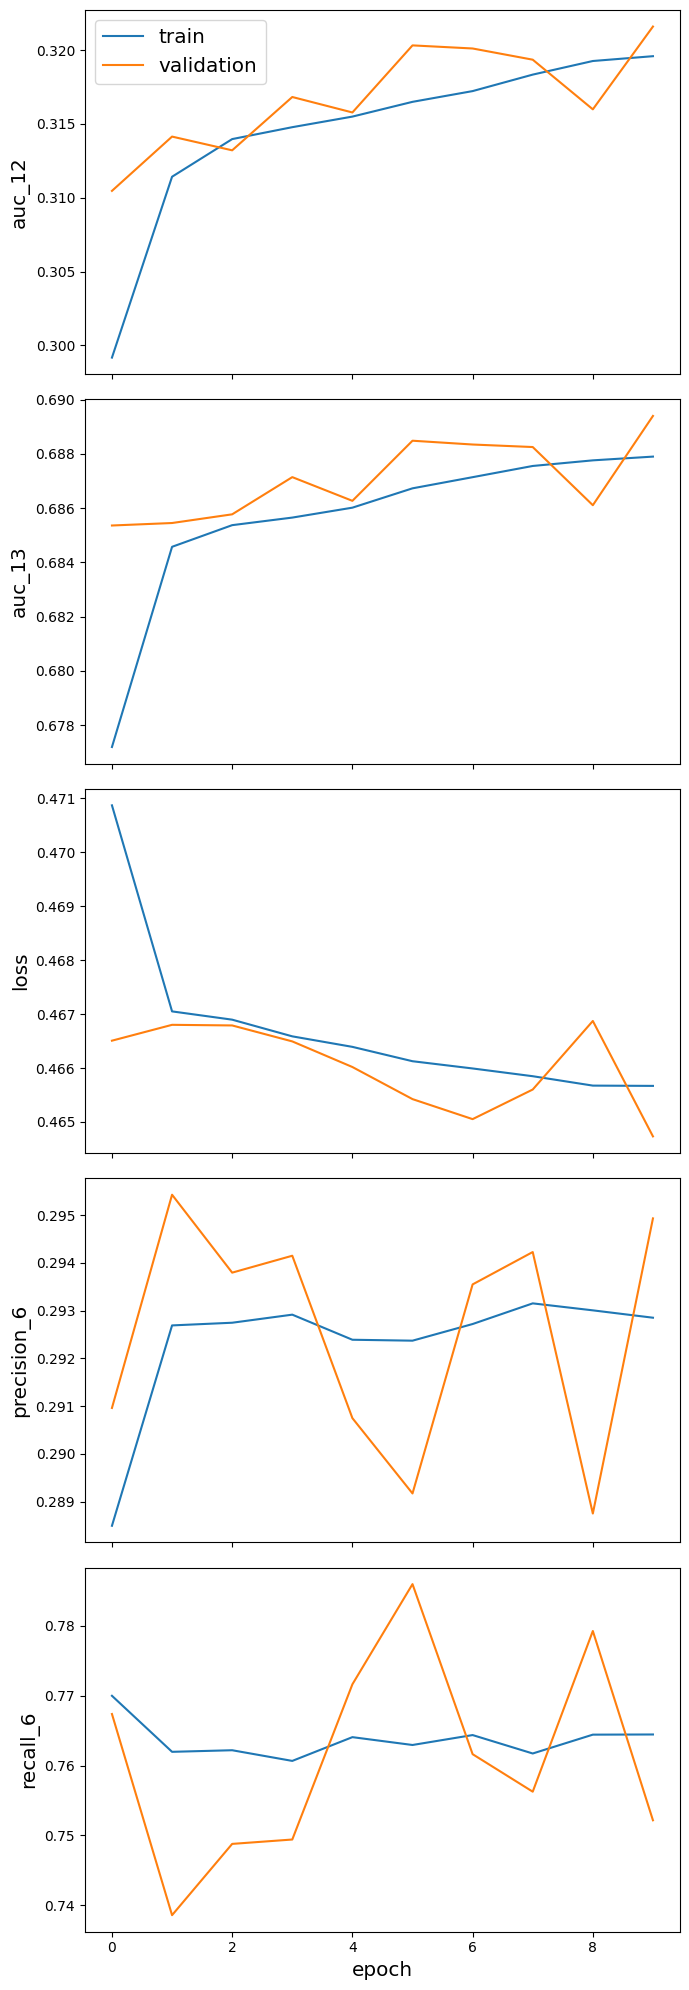

In [71]:
import stellargraph as sg
sg.utils.plot_history(history)